In [1]:
import numpy as np
import pandas as pd
import keras
import matplotlib.pyplot as plt
from keras.models import load_model

import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
# Load the dataset
train = pd.read_csv('data_set/emnist-letters-train.csv')
test = pd.read_csv('data_set/emnist-letters-test.csv')

# Reshape the dataset and preprocess
def preprocess_data(data):
    images = data.iloc[:, 1:].values.astype('float32')
    images = np.apply_along_axis(rotate, 1, images)
    images = images.reshape(images.shape[0], 28, 28, 1)
    print(images[0].shape)
    labels = data.iloc[:, 0].values.astype('int32') - 1  # zero indexing
    return images, labels

def rotate(image):
    image = image.reshape(28, 28)
    return np.fliplr(np.rot90(image, 3)).reshape(784)

image_train, label_train = preprocess_data(train)
image_test, label_test = preprocess_data(test)

# Image Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    zoom_range=0.10,
    width_shift_range=0.1,
    height_shift_range=0.1
)
datagen.fit(image_train)


(28, 28, 1)
(28, 28, 1)


In [3]:
model = load_model('lstm_epochs_128.h5')

2023-10-22 21:24:37.782994: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
# Convert number to text a = 1 ... z = 26
def number_to_text(n):
    if 1 <= n <= 26:
        return chr(96 + n) 
    else:
        raise ValueError("The number should be between 1 and 26.")

In [5]:
loss, accuracy = model.evaluate(image_test, label_test)
print(f"Loss: {loss}, Accuracy: {accuracy}")


463/463 [==============================] - 7s 13ms/step - loss: 0.2179 - accuracy: 0.9260
Loss: 0.21789544820785522, Accuracy: 0.9260085225105286


(14799, 28, 28, 1)


1/1 [==============================] - 1s 841ms/step


IndexError: index 20 is out of bounds for axis 0 with size 20

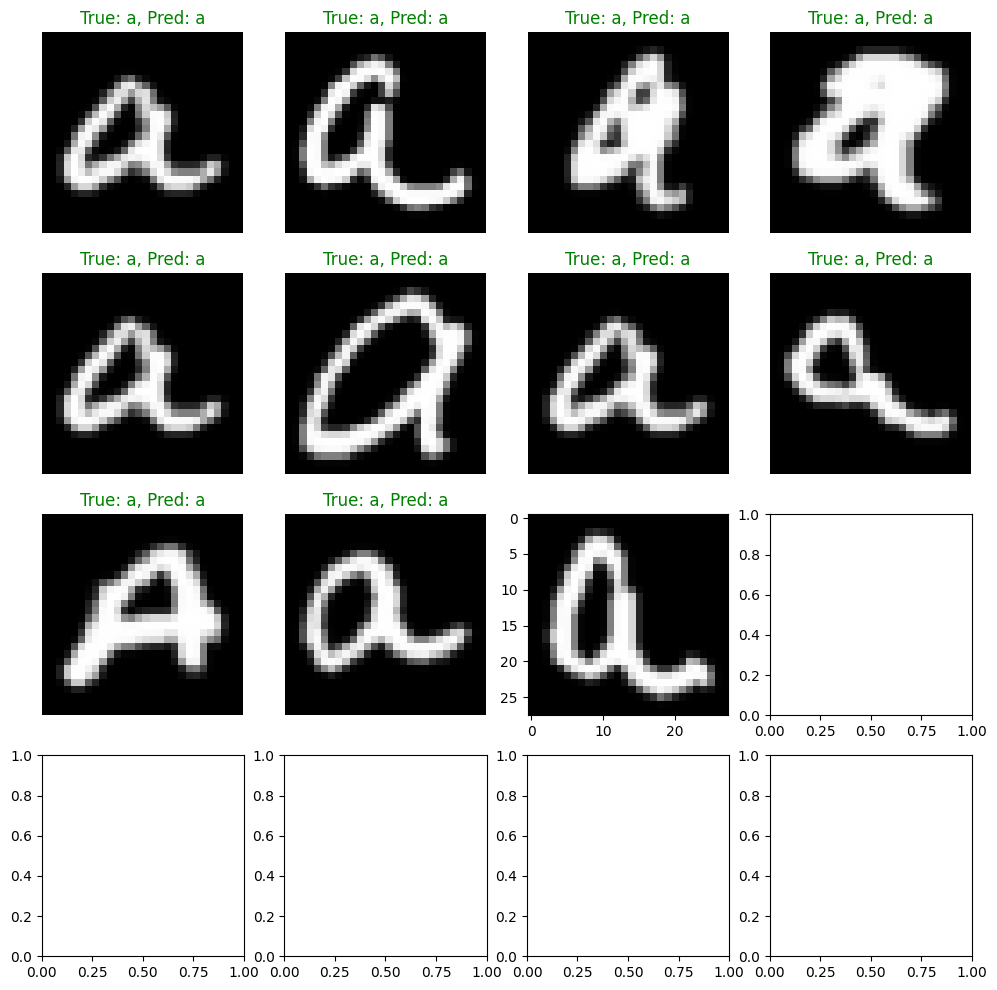

In [6]:
from random import randint

print(image_test.shape)

# Predict
predictions = model.predict(image_test)
max_predictions = len(predictions)

# Visualize predictions
def plot_sample(X, y_true, y_pred, index, ax):
    ax.imshow(X[index].reshape(28, 28), cmap='gray')
    true_label = chr(y_true[index] + 97)  # Convert to ascii and then to char
    pred_label = chr(np.argmax(y_pred[index]) + 97)
    if true_label == pred_label:
        color = 'green'
    else:
        color = 'red'
    ax.set_title(f"True: {true_label}, Pred: {pred_label}", color=color)
    ax.axis('off')

fig, axes = plt.subplots(4, 4, figsize=(12, 12))
axes = axes.ravel()

for i in range(16):
    plot_sample(image_test, label_test, predictions, randint(1,max_predictions), axes[i])
    
plt.tight_layout()
plt.show()


In [ ]:
import os
from random import randint

def save_test_images(X_test, save_dir, num_images=10):
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)
    max = len(X_test)
    for i in range(num_images):
        index = randint(1,max)
        plt.figure(figsize=(2,2))
        plt.imshow(X_test[index].reshape(28, 28), cmap='gray')
        plt.axis('off')
        file_path = os.path.join(save_dir, f"test_image_{index}.png")
        plt.savefig(file_path, bbox_inches='tight', pad_inches=0)
        plt.close()

# Usage:
save_dir = "saved_test_images"
save_test_images(image_test, save_dir, num_images=10)


(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)
(28, 28, 1)


1/1 [==============================] - 0s 36ms/step


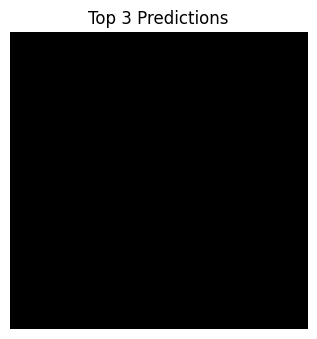

Predicted Character: e


In [17]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
from keras.models import load_model

def predict_from_image(file_path, model):
    img = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
    
    # Resize and preprocess the image
    img = cv2.resize(img, (28, 28))
    # Invert color
    img = 255 - img
    # Reshape image
    img = img.reshape(28, 28, 1)
    img = img[np.newaxis,...]

    # Predict
    prediction = model.predict(img)
    predicted_char = chr(np.argmax(prediction) + 97)
    
    # Get top 3 predictions
    top3_indices = prediction[0].argsort()[-3:][::-1]
    top3_probs = prediction[0][top3_indices]
    top3_chars = [chr(i + 97) for i in top3_indices]
    
    plt.imshow(img.reshape(28, 28), cmap='gray')
    
    print(f"Image: {file_path}")
    for index in range(3):  # Displaying only top 3 predictions
        print(f"  {index + 1}. {top3_chars[index]} ({top3_probs[index]:.2f})")
    
    plt.title("Top 3 Predictions")
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

    return predicted_char

directory_path = 'saved_test_images'

# Iterate over all files in the directory
for filename in os.listdir(directory_path):
    # if filename.endswith('.png'):
    file_path = os.path.join(directory_path, filename)
    predicted_char = predict_from_image(file_path, model)
    print(f"Predicted Character for {filename}: {predicted_char}")
